# Depth dataset analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Dataset of depth captures
DEPTH_DATASET_FILE = '../data/positions/depth.pkl'
# ROI defined for the dataset
ROI_DEFINITION_FILE = '../data/positions/roi.pkl'
# Original image size
ORIGINAL_WIDTH = 640
ORIGINAL_HEIGHT = 480
# These parameters come from intrinsics matrix (RIGHT)
CX = 636.09185791
CY = 357.98129272
FX = 854.11590576
FY = 854.77392578

In [4]:
fid = open(DEPTH_DATASET_FILE, 'rb')
dataset = pickle.load(fid)
fidroi = open(ROI_DEFINITION_FILE, "rb")
roi = pickle.load(fidroi)

In [6]:
roi

{'left_hand': {'topx': 0.70626974,
  'bottomx': 0.9138323,
  'topy': 0.3703948,
  'bottomy': 0.88965607},
 'right_hand': {'topx': 0.28044695,
  'bottomx': 0.6898699,
  'topy': 0.46020508,
  'bottomy': 0.8492034}}

In [5]:
size = len(dataset)
depth_map_dim = dataset[0]['depth_map'].shape
from_ts = dataset[0]['timestamp']
to_ts = dataset[size-1]['timestamp']
from_frame_num = dataset[0]['frame']
to_frame_num = dataset[size-1]['frame']
roi_topx = int(roi['topx'] * ORIGINAL_WIDTH)
roi_bottomx = int(roi['bottomx'] * ORIGINAL_WIDTH)
roi_topy = int(roi['topy'] * ORIGINAL_HEIGHT)
roi_bottomy = int(roi['bottomy'] * ORIGINAL_HEIGHT)

KeyError: 'topx'

## Dataset Metadata

In [6]:
print(f"Dataset size = {size} frames")
print(f"Depth map width = {depth_map_dim[1]} pixels")
print(f"Depth map height = {depth_map_dim[0]} pixels")
print(f"From time = {from_ts}")
print(f"To time = {to_ts}")
print(f"From frame = {from_frame_num}")
print(f"To frame = {to_frame_num}")
print(f"ROI top (x,y) = ({roi_topx},{roi_topy})")
print(f"ROI bottom (x,y) = ({roi_bottomx},{roi_bottomy})")

Dataset size = 92 frames
Depth map width = 330 pixels
Depth map height = 138 pixels
From time = 2021-07-04 15:43:25.510214
To time = 2021-07-04 15:43:28.546247
From frame = 319
To frame = 410
ROI top (x,y) = (104,81)
ROI bottom (x,y) = (433,247)


## Inspect Dataset

In [9]:
CURRENT_SLICE = 0
slice_size = 16
slices = size//slice_size + (0 if size%slice_size==0 else 1)
def show_slice(slice_number):
    global CURRENT_SLICE
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        axs[row,col].imshow(sl_['depth_map'], cmap='Spectral')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()
    CURRENT_SLICE = slice_number

In [10]:
interact(show_slice, 
         slice_number=widgets.IntSlider(min=0, max=slices-1, step=1, description='Select Slice')
)

interactive(children=(IntSlider(value=0, description='Select Slice', max=5), Output()), _dom_classes=('widget-…

<function __main__.show_slice(slice_number)>

## Thresholding Depth Values

In [11]:
# Hard limits
# Max depth
MAX_DEPTH_VALUE = 700
# Min depth
MIN_DEPTH_VALUE = 100

In [12]:
# Show dataset filtered
def show_filtered_slice(slice_number):
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        # Max values turn to 0 for display
        dm_ = sl_['depth_map'].copy()
        filter_1 = dm_ > MAX_DEPTH_VALUE
        dm_[filter_1] = 2**16
        axs[row,col].imshow(dm_, cmap='rainbow')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()

In [13]:
CURRENT_SLICE

2

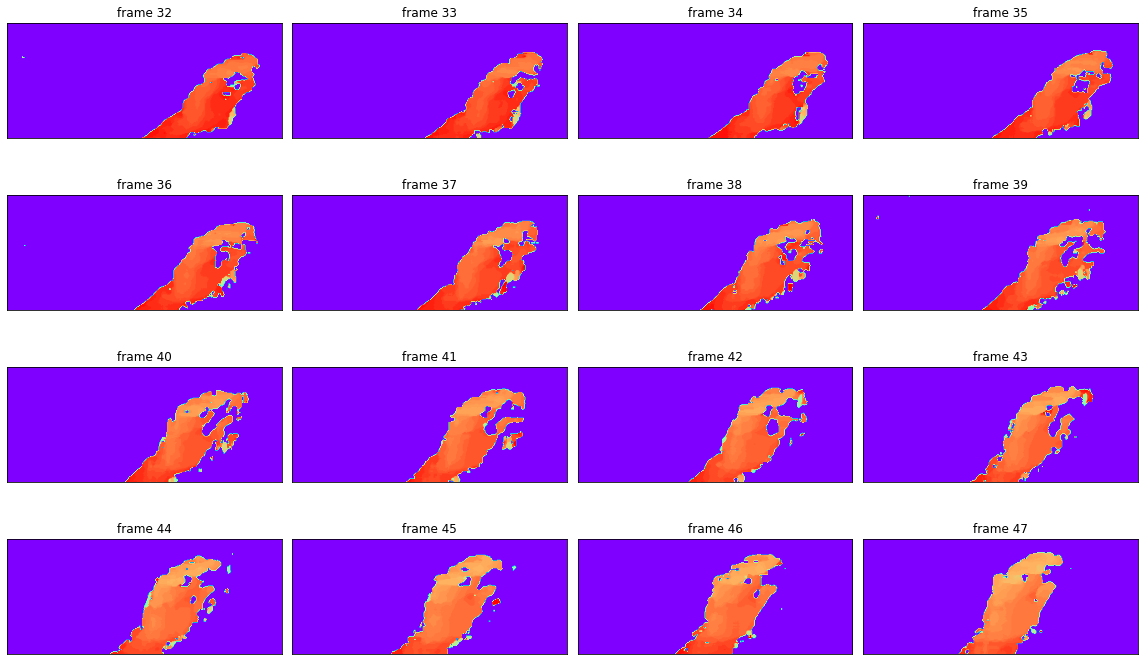

In [14]:
show_filtered_slice(CURRENT_SLICE)

## Select a Frame to inspect

In [15]:
FRAME = 39

In [16]:
dm_frame = dataset[FRAME]['depth_map']
frame_number = dataset[FRAME]['frame']
ts = dataset[FRAME]['timestamp']

In [17]:
filter_cond = (dm_frame > MAX_DEPTH_VALUE) | (dm_frame < MIN_DEPTH_VALUE)
dm_frame_filtered = dm_frame.copy()
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
dm_frame_filtered_values = dm_frame[~filter_cond].flatten()
dm_frame_filtered[filter_cond] = 2**16

In [18]:
# Some statistics of the frame depth values
print("Statistics of Thresholed Frame")
print(f"Size = {len(dm_frame_filtered_values)}")
print(f"Min = {np.max(dm_frame_filtered_values)}")
print(f"Max = {np.min(dm_frame_filtered_values)}")
print(f"Mean = {np.mean(dm_frame_filtered_values)}")
print(f"Median = {np.median(dm_frame_filtered_values)}")
print(f"Std = {np.std(dm_frame_filtered_values)}")

Statistics of Thresholed Frame
Size = 6778
Min = 690
Max = 349
Mean = 600.2246975508999
Median = 614.0
Std = 39.97240266933345


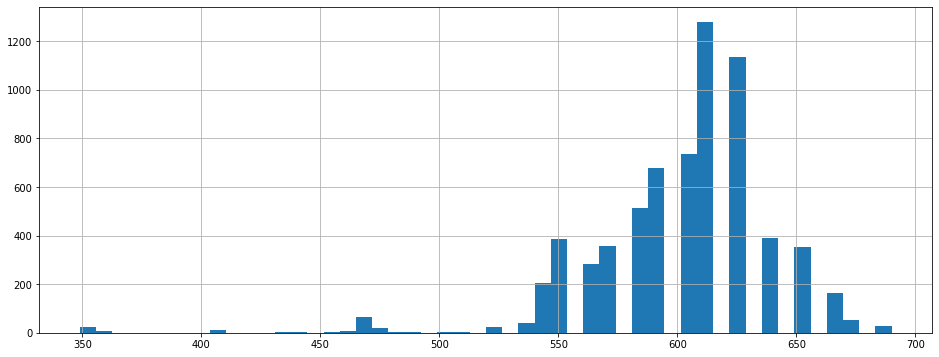

In [19]:
fig = plt.figure(figsize=(16,6))
plt.grid()
plt.hist(dm_frame_filtered_values, bins=50)
plt.show()

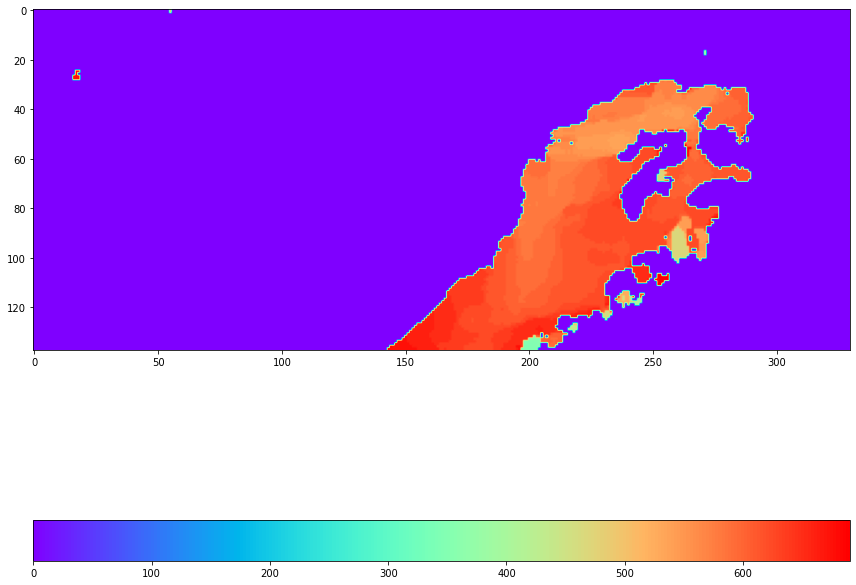

In [20]:
fig = plt.figure(figsize=(12,16))
plt.imshow(dm_frame_filtered, cmap='rainbow')
plt.colorbar(orientation='horizontal')
fig.tight_layout()
plt.show()

## Write a slice into point cloud files for future inspection

In [59]:
# Numpy version is faster
def xyz_numpy(frame, idxs, topx, topy, cx, cy, fx, fy):
    u = idxs[:,1]
    v = idxs[:,0]
    z = frame[v,u]
    x = ((u + topx - cx)*z)/fx
    y = ((v + topy - cy)*z)/fy
    return x, y, z

In [60]:
def xyz(frame, idxs, topx, topy, cx, cy, fx, fy):
    xyz_c = []
    for v, u in idxs:
        z = frame[v, u]
        x = ((u + topx - cx)*z)/fx
        y = ((v + topy - cy)*z)/fy
        xyz_c.append([x,y,z])
    return xyz_c

In [61]:
CURRENT_SLICE

2

In [58]:
print(f"Writing Current Slice {CURRENT_SLICE}")
slice_ = dataset[CURRENT_SLICE*slice_size:min(CURRENT_SLICE*slice_size+slice_size,size)]
for sl_ in slice_:
    dm_ = sl_['depth_map'].copy()
    fn = sl_['frame']
    filter_cond = (dm_ > MAX_DEPTH_VALUE) | (dm_ < MIN_DEPTH_VALUE)
    dm_frame_filtered_idxs = np.argwhere(~filter_cond)
    x, y, z = xyz_numpy(dm_, dm_frame_filtered_idxs, roi_topx, roi_topy, CX, CY, FX, FY)
    # write to file
    filename = f"{fn}.xyz"
    print(f"Writing file {filename}")
    fd = open(filename, 'w')
    for i,j,k in zip(x, y, z):
        fd.write(f"{i} {j} {k}\n")
    fd.close()

Writing Current Slice 2
Writing file 351.xyz
Writing file 352.xyz
Writing file 353.xyz
Writing file 354.xyz
Writing file 355.xyz
Writing file 356.xyz
Writing file 357.xyz
Writing file 358.xyz
Writing file 359.xyz
Writing file 360.xyz
Writing file 361.xyz
Writing file 362.xyz
Writing file 363.xyz
Writing file 364.xyz
Writing file 365.xyz
Writing file 366.xyz
